<a href="https://colab.research.google.com/github/tainguyen30/AI-2022-2023/blob/main/Control%20DC%20Motor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

pip install -U scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 KB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894088 sha256=82ad023acb05a7c8e6046538243c1accca26ff489a0d35b14fdc1df77ee9a151
  Stored in directory: /root/.cache/pip/wheels/32/2c/a1/a90a7d7dd8448ec029f298a61f3490275e99b17aa348be675c
Successfully built scikit-fuzzy


111.34692939861355
123.50997840753445
155.268771287599


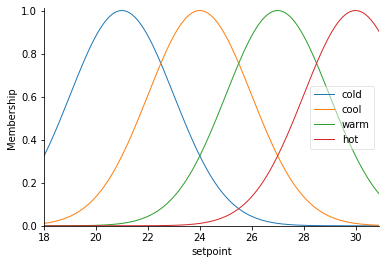

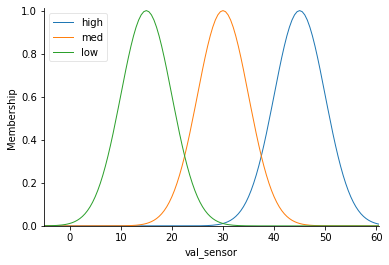

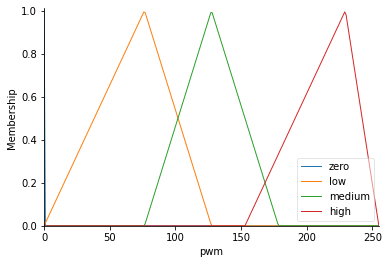

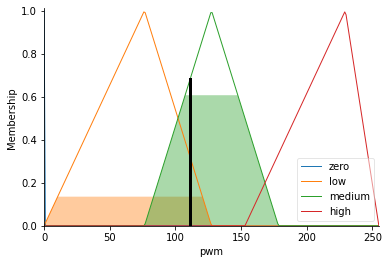

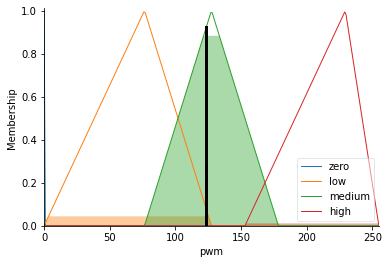

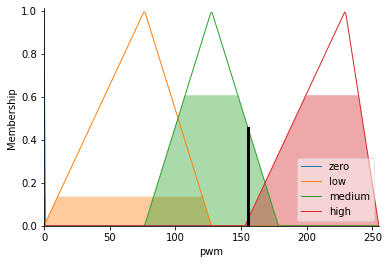

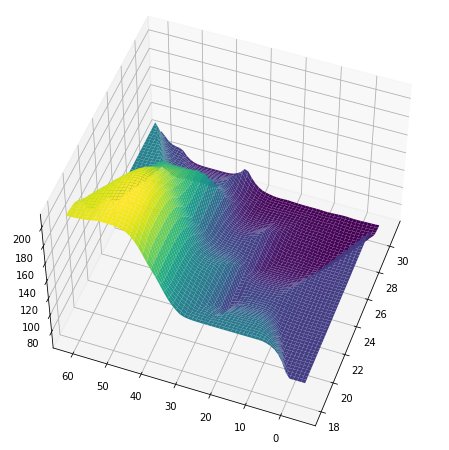

In [23]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axis3d

setpoint = ctrl.Antecedent(np.arange(18, 31, 0.1), 'setpoint')
val_sensor = ctrl.Antecedent(np.arange(-5, 61, 0.5), 'val_sensor')
pwm = ctrl.Consequent(np.arange(0, 256, 1), 'pwm')

setpoint['cold'] = fuzz.gaussmf(setpoint.universe, 21, 2)
setpoint['cool'] = fuzz.gaussmf(setpoint.universe, 24, 2)
setpoint['warm'] = fuzz.gaussmf(setpoint.universe, 27, 2)
setpoint['hot'] = fuzz.gaussmf(setpoint.universe, 30, 2)

val_sensor['high'] = fuzz.gaussmf(val_sensor.universe, 45, 5)
val_sensor['med'] = fuzz.gaussmf(val_sensor.universe, 30, 5)
val_sensor['low'] = fuzz.gaussmf(val_sensor.universe, 15, 5)

pwm['zero'] = fuzz.trimf(pwm.universe, [0, 0, 0])
pwm['low'] = fuzz.trimf(pwm.universe, [0, 76.5, 127.5])
pwm['medium'] = fuzz.trimf(pwm.universe, [76.5, 127.5, 178.5])
pwm['high'] = fuzz.trimf(pwm.universe, [153, 229.5, 255])

setpoint.view()
val_sensor.view()
pwm.view()

# Rules
rule0 = ctrl.Rule(setpoint['cold'] & val_sensor['high'], pwm['high'])
rule1 = ctrl.Rule(setpoint['cool'] & val_sensor['high'], pwm['high'])
rule2 = ctrl.Rule(setpoint['warm'] & val_sensor['high'], pwm['medium'])
rule3 = ctrl.Rule(setpoint['hot'] & val_sensor['high'], pwm['low'])

rule4 = ctrl.Rule(setpoint['cold'] & val_sensor['med'], pwm['medium'])
rule5 = ctrl.Rule(setpoint['cool'] & val_sensor['med'], pwm['medium'])
rule6 = ctrl.Rule(setpoint['warm'] & val_sensor['med'], pwm['low'])
rule7 = ctrl.Rule(setpoint['hot'] & val_sensor['med'], pwm['zero'])

rule8 = ctrl.Rule(setpoint['cold'] & val_sensor['low'], pwm['medium'])
rule9 = ctrl.Rule(setpoint['cool'] & val_sensor['low'], pwm['low'])
rule10 = ctrl.Rule(setpoint['warm'] & val_sensor['low'], pwm['low'])
rule11 = ctrl.Rule(setpoint['hot'] & val_sensor['low'], pwm['zero'])

# Control System
pwm_ctrl = ctrl.ControlSystem([rule0, rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11])
pwm1 = ctrl.ControlSystemSimulation(pwm_ctrl)
pwm1.input['val_sensor'] = 20
pwm1.input['setpoint'] = 20
pwm1.compute()
print(pwm1.output['pwm'])
pwm.view(sim=pwm1)

pwm1.input['val_sensor'] = 30
pwm1.input['setpoint'] = 22
pwm1.compute()
print(pwm1.output['pwm'])
pwm.view(sim=pwm1)

pwm1.input['val_sensor'] = 40
pwm1.input['setpoint'] = 26
pwm1.compute()
print(pwm1.output['pwm'])
pwm.view(sim=pwm1)

# 3D
system = ctrl.ControlSystem([rule0, rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11])
sim = ctrl.ControlSystemSimulation(system, flush_after_run=61 * 61 + 1)
upsampled = np.linspace(18, 31, 61)
upsampled1 = np.linspace(-5, 61, 61)
x, y = np.meshgrid(upsampled, upsampled1)
z = np.zeros_like(x)
for i in range(61):
    for j in range(61):
        sim.input['setpoint'] = x[i, j]
        sim.input['val_sensor'] = y[i, j]
        sim.compute()
        z[i, j] = sim.output['pwm']

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
suf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis', linewidth=0.4, antialiased=True)

# cset = ax.contourf(x, y, z, zdir='z', offset=6, cmap='viridis', anpha=0.5)
# cset = ax.contourf(x, y, z, zdir='x', offset=9, cmap='viridis', anpha=0.5)
# cset = ax.contourf(x, y, z, zdir='y', offset=9, cmap='viridis', anpha=0.5)
ax.view_init(50, 200)
